# Historical Stock Price Collection and Analysis

## Overview:
In this notebook, we will collect and analyze historical stock price data using `yfinance` and other Python libraries. We will calculate log returns, visualize the OHLC (Open, High, Low, Close) charts, and save the processed data to CSV files for future analysis. The notebook supports processing data for multiple stock tickers and includes a function to automate this workflow.

## Steps:
1. **Data Fetching**: We will use the `yfinance` library to fetch historical stock price data for specified tickers and a given date range.
2. **Log Returns Calculation**: Logarithmic returns between consecutive closing prices will be computed to understand the rate of return on the stock.
3. **Data Export**: The stock price data, along with the log returns, will be saved to a CSV file for further analysis.
4. **OHLC Chart Visualization**: We will generate time-series visualizations of the OHLC data, with volume plotted as bars in the background, to give a clear view of stock price movements.
5. **Batch Processing**: The notebook supports processing multiple stock tickers in one run, saving each ticker's data and visualizations independently.

#### Importing necessary libraries
In this cell, we are importing essential libraries for fetching stock data, manipulating dataframes, visualizing data, and performing statistical analysis. The following libraries are used:
- `yfinance`: Fetching historical stock data.
- `pandas`: Data manipulation and handling.
- `numpy`: For numerical operations like log returns.
- `matplotlib` and `mplfinance`: For plotting OHLC charts.
- `statsmodels`: For time-series analysis, including stationarity checks (ADF test).

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from statsmodels.tsa.stattools import adfuller


#### Function to fetch historical stock data
This cell defines a function `fetch_stock_data` that uses `yfinance` to retrieve stock data for a given ticker and date range. The function returns a DataFrame containing historical stock prices.

**Parameters:**
- `ticker`: Stock ticker symbol (e.g., 'AAPL').
- `start_date`: The start date for fetching data in 'YYYY-MM-DD' format.
- `end_date`: The end date for fetching data in 'YYYY-MM-DD' format.

**Returns:**
- A pandas DataFrame containing stock price data.

In [ ]:
def fetch_stock_data(ticker, start_date, end_date): 
    """ 
    Fetch historical stock price data using yfinance.
    Parameters:
        ticker (str): Stock ticker symbol.
        start_date (str): Start date in the format 'YYYY-MM-DD'.
        end_date (str): End date in the format 'YYYY-MM-DD'.

    Returns:
    pd.DataFrame: Stock price data.
    """
    stock_data = yf.download(ticker, start=start_date, end=end_date)

    # Replace spaces in column names with underscores
    stock_data.columns = stock_data.columns.str.replace(' ', '_')
    
    return stock_data

#### Function to calculate log returns
This function calculates various log returns for stock price data, which gives insight into stock performance over time.

**Parameters:**
- `data`: DataFrame containing stock prices.

**Returns:**
- The input DataFrame with new columns for log returns:
  - `Log_Return_Close_Close`: Between consecutive closing prices.
  - `Log_Return_Open_Close`: Between the same day's open and close.
  - `Log_Return_High_Low`: Between the same day's high and low.
  - `Log_Return_Open_Open`: Between consecutive open prices.
  - `Log_Return_Close_Open`: Between the previous close and the next day's open.


In [ ]:
def calculate_log_returns(data):
    """
    Calculate log returns for different price points from stock price data.
    
    Parameters:
    data (pd.DataFrame): Stock price data with 'Open', 'High', 'Low', 'Close', and 'Adj Close' prices.
    
    Returns:
    pd.DataFrame: DataFrame with added columns for various log returns.
    """
    # Close to Close (Consecutive Days)
    data['Log_Return_Close_Close'] = np.log(data['Adj_Close'] / data['Adj_Close'].shift(1))

    # Open to Close (Same Day)
    data['Log_Return_Open_Close'] = np.log(data['Close'] / data['Open'])

    # High to Low (Same Day)
    data['Log_Return_High_Low'] = np.log(data['High'] / data['Low'])

    # Open to Open (Consecutive Days)
    data['Log_Return_Open_Open'] = np.log(data['Open'] / data['Open'].shift(1))

    # Close to Open (Next Day Open)
    data['Log_Return_Close_Open'] = np.log(data['Open'] / data['Close'].shift(1))

    # Drop NaN rows generated by the shift operation
    return data.dropna()



#### Function to apply differencing to time series
This function calculates the first difference of a time series to make it stationary, which is often useful for time-series modeling.

**Parameters:**
- `data`: DataFrame containing the time series.
- `column`: The column name on which to apply differencing.

**Returns:**
- The DataFrame with a new column for the differenced series.


In [ ]:
def calculate_differencing(data, column):
    """
    Apply differencing to make the time series data stationary.
    
    Parameters:
    data (pd.DataFrame): The time series data with stock prices or other time series values.
    column (str): The column name of the time series to be differenced.
    
    Returns:
    pd.DataFrame: DataFrame with added column for differenced time series.
    """
    # Differencing Method
    data[f'Differenced_{column}'] = data[column] - data[column].shift(1)

    # Drop NaN rows generated by the shift operation
    return data.dropna()


#### Function to save stock data to a CSV file
This function saves the processed stock data (including log returns) to a CSV file for future analysis.

**Parameters:**
- `data`: DataFrame containing stock price data and log returns.
- `ticker`: The stock ticker symbol.
- `folder`: The folder path where the CSV file will be saved (default is `data`).

**Returns:**
- None. The function prints a message indicating the file has been saved.


In [ ]:
def save_to_csv(data, ticker, folder='data'):
    """
    Save the stock data to a CSV file.
    
    Parameters:
    data (pd.DataFrame): Stock price data with log returns.
    ticker (str): Stock ticker symbol.
    folder (str): Folder path to save the CSV.
    
    Returns:
    None
    """
    filename = f"../{folder}/processed/{ticker}.csv"
    data.to_csv(filename)
    print(f"Data saved to {filename}")


#### Function to plot OHLC chart with volume
This function generates an OHLC (Open, High, Low, Close) time series chart using `mplfinance`, with the volume displayed as bars in the background.

**Parameters:**
- `data`: DataFrame containing stock price data (Open, High, Low, Close, Volume).
- `ticker`: The stock ticker symbol.

**Returns:**
- None. The OHLC chart is displayed.

In [ ]:
def plot_ohlc_chart_with_volume(data, ticker):
    """
    Plot OHLC time series chart with volume bars in the background using mplfinance.
    
    Parameters:
    data (pd.DataFrame): DataFrame containing 'Open', 'High', 'Low', 'Close', and 'Volume' prices and date index.
    ticker (str): The stock ticker symbol.
    
    Returns:
    None
    """
    data.index = pd.to_datetime(data.index)

    # Plot OHLC chart using mplfinance with volume bars
    mpf.plot(
        data,
        type='ohlc',
        style='yahoo',
        title=f'OHLC Time Series for {ticker}',
        ylabel='Price',
        volume=True,
        ylabel_lower='Volume',
        figratio=(10, 7),
        figscale=1.2,
        show_nontrading=False
    )
    plt.show()


#### Function to plot differenced 'Adj Close' series
This function plots the differenced 'Adj Close' price series to check for stationarity, which is important for time-series modeling.

**Parameters:**
- `data`: DataFrame containing the differenced 'Adj Close' column.
- `ticker`: The stock ticker symbol.

**Returns:**
- None. The differenced series plot is displayed.

In [ ]:
def plot_differenced_adj_close(data, ticker):
    """
    Plot the Differenced 'Adj Close' time series to check for stationarity.
    
    Parameters:
    data (pd.DataFrame): DataFrame containing 'Differenced_Adj_Close' and date index.
    ticker (str): The stock ticker symbol.
    
    Returns:
    None
    """
    # Ensure the index is a datetime type
    data.index = pd.to_datetime(data.index)

    # Plot the Differenced Adj Close
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Differenced_Adj_Close'], label='Differenced Adj Close', color='blue')

    # Chart details
    plt.title(f'Differenced Adj Close for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Differenced Adj Close')
    plt.legend()
    plt.grid(True)

    # Display the plot
    plt.show()

In [ ]:
#### Function to run the Augmented Dickey-Fuller (ADF) test
This function performs the Augmented Dickey-Fuller test to check for the stationarity of a time series. The ADF test is crucial for time-series analysis to determine if the series is suitable for ARIMA modeling.

**Parameters:**
- `data`: DataFrame containing the time series data.
- `column`: The column name of the time series to be tested for stationarity.

**Returns:**
- None: The function prints the ADF test statistic, p-value, and critical values to assess stationarity.

**Usage:**
- This test helps in determining whether to difference the data further or if it's ready for forecasting methods that assume stationarity.


In [ ]:
def run_adf_test(data, column):
    """
    Run the Augmented Dickey-Fuller (ADF) test to check for stationarity.
    
    Parameters:
    data (pd.DataFrame): DataFrame containing the time series data.
    column (str): The column name of the time series to be tested.
    
    Returns:
    None: Prints the ADF test results.
    """
    # Extract the column as a pandas Series
    timeseries = data[column].dropna()

    # Run ADF test
    result = adfuller(timeseries)

    # Print the test statistic and p-value
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')

    # Print critical values
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value}')

    # Interpret the p-value
    if result[1] < 0.05:
        print("\nThe time series is stationary.")
    else:
        print("\nThe time series is not stationary.")

#### Function to run the complete workflow
This function encapsulates the entire process of fetching stock data, calculating log returns, differencing the data, running the ADF test, saving results to CSV, and plotting. It is designed to be run with a single call, making it efficient for batch processing multiple tickers.

**Parameters:**
- `ticker`: The stock ticker symbol.
- `start_date`: Start date in 'YYYY-MM-DD' format.
- `end_date`: End date in 'YYYY-MM-DD' format.

**Returns:**
- None: This function performs operations and generates files and plots without returning any objects.

**Workflow Steps:**
1. **Fetch Data**: Retrieve stock price data using the specified ticker and date range.
2. **Calculate Log Returns**: Compute log returns to analyze the rate of return on the stock.
3. **Calculate Differencing**: Apply differencing to make the data stationary if necessary.
4. **Run ADF Test**: Check for stationarity of the differenced data.
5. **Save Data**: Export the processed data to a CSV file.
6. **Plot Data**: Generate visualizations for both the OHLC data and the differenced data.

In [ ]:
def run_workflow(ticker, start_date, end_date):
    """
    Main workflow function to fetch data, calculate log returns, save to CSV, and plot OHLC chart.
    
    Parameters:
    ticker (str): Stock ticker symbol.
    start_date (str): Start date in the format 'YYYY-MM-DD'.
    end_date (str): End date in the format 'YYYY-MM-DD'.
    
    Returns:
    None
    """
    # Fetch stock data
    stock_data = fetch_stock_data(ticker, start_date, end_date)

    # Calculate log returns
    stock_data = calculate_log_returns(stock_data)
    
    #Caluclaute percentage simple returns
    stock_data = calculate_differencing(stock_data, 'Adj_Close')

    run_adf_test(stock_data,'Differenced_Adj_Close')
    
    # Save data to CSV
    save_to_csv(stock_data, ticker)

    # Plot OHLC chart
    plot_ohlc_chart_with_volume(stock_data, ticker)
    plot_differenced_adj_close(stock_data, ticker)



[*********************100%***********************]  1 of 1 completed
C:\Users\erikp\AppData\Local\Temp\ipykernel_31264\911960552.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Differenced_{column}'] = data[column] - data[column].shift(1)
C:\CoDE\Scoop\apps\python\current\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ===========================

ADF Statistic: -12.711543413098694
p-value: 1.0275821829836477e-23
Critical Value (1%): -3.432135020388135
Critical Value (5%): -2.862328722835932
Critical Value (10%): -2.5671898489444147

The time series is stationary.
Data saved to ../data/processed/SPY.csv


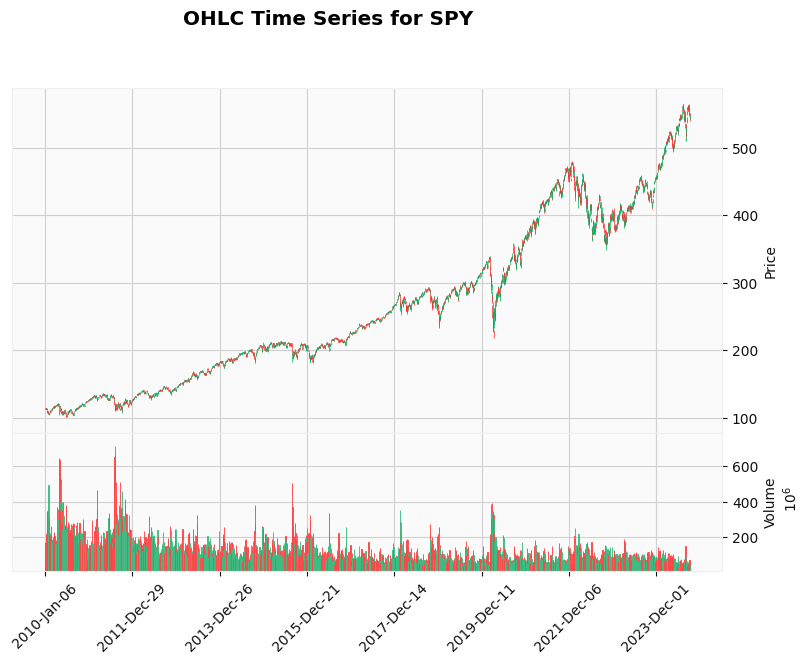

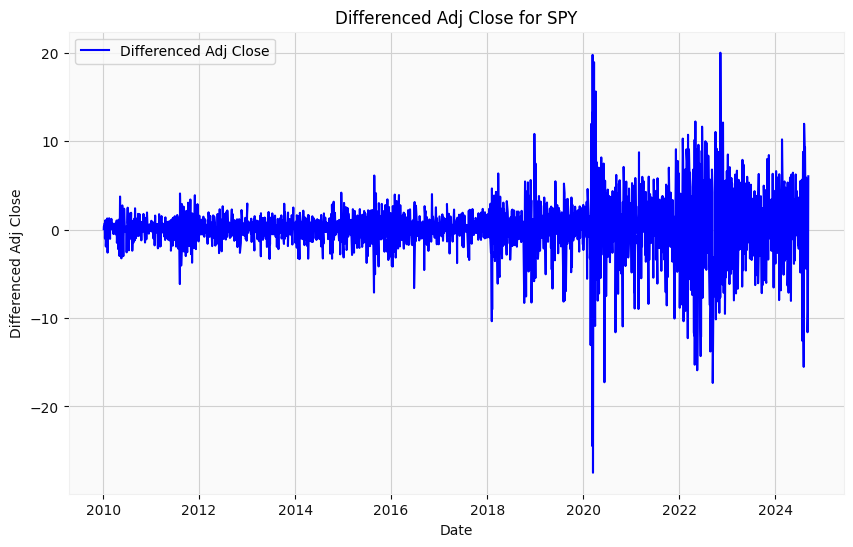

In [97]:
# Example usage
ticker = 'SPY'
start_date = '2010-01-01'
end_date = '2024-09-10'

run_workflow(ticker, start_date, end_date)
